# with langgrpah

In [ ]:
from typing import Annotated, Sequence, TypedDict
from dataclasses import dataclass
from langgraph.graph import StateGraph, END
#from langgraph.utils.input_annotations import add_messages
from operator import add as add_messages

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage


class State(TypedDict):
    topic: str
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Define node: simulate LLM replying to the last human message
def respond_node(state: State) -> dict:
    last_msg = state["messages"][-1].content 
    reply = f"Echo: {last_msg}"             
    new_ai_msg = AIMessage(content=reply)
    return {"messages": [new_ai_msg]}         

# Build graph
graph = (
    StateGraph(State)
    .add_node("respond", respond_node)
    .set_entry_point("respond")
    .add_edge("respond", END)
    .compile()
)



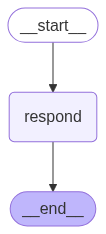

In [15]:
graph

In [32]:

# First run — with one user message
state1 = {
    "topic": "chat",
    "messages": [HumanMessage(content="Hello, who are you?")]
}
result1 = graph.invoke(state1)



In [33]:
result1

{'topic': 'chat',
 'messages': [HumanMessage(content='Hello, who are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Echo: Hello, who are you?', additional_kwargs={}, response_metadata={})]}

In [26]:
result1["messages"]

[HumanMessage(content='Hello, who are you?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Echo: Hello, who are you?', additional_kwargs={}, response_metadata={})]

In [23]:
print("=== After First Call ===")
for m in result1["messages"]:
    print(f"{m.__class__.__name__}: {m.content}")

=== After First Call ===
HumanMessage: Hello, who are you?
AIMessage: Echo: Hello, who are you?


In [34]:

# Second run — send back the updated message list
state2 = {
    "topic": "chat",
    "messages":  [HumanMessage(content="Tell me a joke.")]
}
result2 = graph.invoke(state2)


In [35]:
result2

{'topic': 'chat',
 'messages': [HumanMessage(content='Tell me a joke.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Echo: Tell me a joke.', additional_kwargs={}, response_metadata={})]}

In [40]:
# with  CONFIG

In [ ]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from operator import add as add_messages

# Define the state - add_messages will handle accumulation
class State(TypedDict):
    topic: str
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Define node: simulate LLM replying to the last human message
def respond_node(state: State) -> dict:
    last_msg = state["messages"][-1].content  
    reply = f"Echo: {last_msg}"             
    new_ai_msg = AIMessage(content=reply)
    return {"messages": [new_ai_msg]}        


checkpointer = MemorySaver()
graph = (
    StateGraph(State)
    .add_node("respond", respond_node)
    .set_entry_point("respond")
    .add_edge("respond", END)
    .compile(checkpointer=checkpointer)
)

# Now add_messages works its magic! ✨
config = {"configurable": {"thread_id": "conversation-1"}}

# First run - just send the new message
result1 = graph.invoke({
    "topic": "chat",
    "messages": [HumanMessage(content="Hello, who are you?")]
},config=config)

print("After first message:")
for msg in result1["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")

# Second run - just send the NEW message, add_messages handles the rest!
result2 = graph.invoke({
    "messages": [HumanMessage(content="Tell me a joke.")]
},config=config)

print("\nAfter second message:")
for msg in result2["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")

# Third run - keep the conversation going
result3 = graph.invoke({
    "messages": [HumanMessage(content="What's the weather like?")]
},config=config)

print("\nAfter third message:")
for msg in result3["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")



After first message:
  HumanMessage: Hello, who are you?
  AIMessage: Echo: Hello, who are you?

After second message:
  HumanMessage: Hello, who are you?
  AIMessage: Echo: Hello, who are you?
  HumanMessage: Tell me a joke.
  AIMessage: Echo: Tell me a joke.

After third message:
  HumanMessage: Hello, who are you?
  AIMessage: Echo: Hello, who are you?
  HumanMessage: Tell me a joke.
  AIMessage: Echo: Tell me a joke.
  HumanMessage: What's the weather like?
  AIMessage: Echo: What's the weather like?


In [42]:
# Different conversation thread
config2 = {"configurable": {"thread_id": "conversation-2"}}
result4 = graph.invoke({
    "topic": "different_chat",
    "messages": [HumanMessage(content="Start fresh conversation")]
}, config2)

print("\nNew conversation thread:")
for msg in result4["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")


New conversation thread:
  HumanMessage: Start fresh conversation
  AIMessage: Echo: Start fresh conversation


In [38]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from operator import add as add_messages

class State(TypedDict):
    topic: str
    messages: Annotated[Sequence[BaseMessage], add_messages]

def respond_node(state: State) -> dict:
    last_msg = state["messages"][-1].content
    reply = f"Echo: {last_msg}"
    new_ai_msg = AIMessage(content=reply)
    return {"messages": [new_ai_msg]}  # add_messages works HERE within the execution

# Compile without checkpointer
graph = (
    StateGraph(State)
    .add_node("respond", respond_node)
    .set_entry_point("respond")
    .add_edge("respond", END)
    .compile()  # Fixed: Added compile()
)

print("=== WITHOUT CHECKPOINTER ===")

# First run - add_messages works WITHIN this execution
result1 = graph.invoke({
    "topic": "chat",
    "messages": [HumanMessage(content="Hello, who are you?")]
})

print("After first message:")
for msg in result1["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")

# Second run - NO MEMORY! Previous messages are lost
result2 = graph.invoke({
    "messages": [HumanMessage(content="Tell me a joke.")]
})

print("\nAfter second message (previous messages LOST!):")
for msg in result2["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")

print("\n" + "="*50)
print("SOLUTION: You need to manually maintain history")
print("="*50)

# Manual approach (what you were doing originally)
result3 = graph.invoke({
    "topic": "chat",
    "messages": result1["messages"] + [HumanMessage(content="What's the weather?")]
})

print("\nWith manual history management:")
for msg in result3["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")

=== WITHOUT CHECKPOINTER ===
After first message:
  HumanMessage: Hello, who are you?
  AIMessage: Echo: Hello, who are you?

After second message (previous messages LOST!):
  HumanMessage: Tell me a joke.
  AIMessage: Echo: Tell me a joke.

SOLUTION: You need to manually maintain history

With manual history management:
  HumanMessage: Hello, who are you?
  AIMessage: Echo: Hello, who are you?
  HumanMessage: What's the weather?
  AIMessage: Echo: What's the weather?


# json st stream

In [ ]:
from langchain_core.runnables import Runnable
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage

from google.generativeai.types import GenerationConfig


import google.generativeai as genai
from dotenv import load_dotenv
import os

from langchain_google_genai import ChatGoogleGenerativeAI




load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEYJ")


llm_json = genai.GenerativeModel(
    model_name="gemini-2.0-flash-lite",
    generation_config=GenerationConfig(
        response_mime_type="application/json",
        temperature=0
    )
)



In [3]:
llm_json

genai.GenerativeModel(
    model_name='models/gemini-2.0-flash-lite',
    generation_config={'temperature': 0, 'response_mime_type': 'application/json'},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

In [4]:

# Create a ChatPromptTemplate
json_prompt = ChatPromptTemplate.from_template("""
You are a helpful assistant.
Extract the presenting problem and emotional history from the following text as JSON only.

Text: {input}

Respond in this JSON format only:
{{
  "presenting_problem": "...",
  "history": "..."
}}
""")

# Chain: prompt → LLM
json_chain: Runnable = json_prompt | llm_json

# Input text to test
user_input = "I yelled at my son again. I feel terrible like I’m failing as a parent. This has been going on for weeks."

# Streaming the response
print("\n[Streaming JSON Extraction Output]\n")
stream = json_chain.stream({"input": user_input})

for chunk in stream:
    print(chunk.content, end="", flush=True)


TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'google.generativeai.generative_models.GenerativeModel'>

# using ChatGoogleGenerativeAI to solve error

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import Runnable
from langchain_core.messages import AIMessageChunk

import os
from dotenv import load_dotenv
load_dotenv()

# Get API key
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

# Gemini LangChain wrapper
llm_json = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # or gemini-1.5-pro
    google_api_key=GEMINI_API_KEY,
    temperature=0,
   # convert_system_message_to_human=True,
   # stream=True  # <-- important for streaming
)

# JSON extraction prompt
json_prompt = ChatPromptTemplate.from_template("""
You are a helpful assistant.
Extract the presenting problem and emotional history from the following text as JSON only.

Text: {input}

Respond in this JSON format only:
{{
  "presenting_problem": "...",
  "history": "..."
}}
""")

# Runnable chain
json_chain: Runnable = json_prompt | llm_json

# Test input
user_input = "I yelled at my son again. I feel terrible like I’m failing as a parent. This has been going on for weeks."

# Stream output
print("\n[Streaming JSON Extraction Output]\n")
stream = json_chain.stream({"input": user_input})

for chunk in stream:
    if isinstance(chunk, AIMessageChunk):
        print(chunk.content, end="", flush=True)



[Streaming JSON Extraction Output]

```json
{
  "presenting_problem": "Yelling at son, feeling terrible and like a failure as a parent",
  "history": "This pattern of yelling has been occurring for weeks."
}
```
